### Data Loading & Util Functions

In [ ]:
import numpy as np

data_path = "/content/drive/MyDrive/data"
color_processed = np.load(f"{data_path}/color_processed.npy")
gray_processed = np.load(f"{data_path}/gray_processed.npy")

In [ ]:
X_train, X_valid = gray_processed[:6000], gray_processed[6000:]
Y_train, Y_valid = color_processed[:6000], color_processed[6000:]

In [ ]:
import torch
import numpy as np

def normalize_create_tensor(data):
  """
  Normalize data and create a tensor
  """
  n = len(data)
  data_scaled = data.astype(np.float32)/255.0
  data_reshaped = np.transpose(data_scaled, (0,3,1,2))
  data_tensor = torch.tensor(data_reshaped)
  # print(f'Shape: {data_tensor.shape}')  # Expected shape: (N, 3, 150, 150)
  # print(f'Type: {data_tensor.dtype}')   # Should be torch.float32
  return data_tensor

In [ ]:
X_train_tensor = normalize_create_tensor(X_train)
Y_train_tensor = normalize_create_tensor(Y_train)

X_valid_tensor = normalize_create_tensor(X_valid)
Y_valid_tensor = normalize_create_tensor(Y_valid)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training loss')
    plt.plot(valid_losses, label=f'Validation loss')
    plt.title(f'Loss Curves: {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from PIL import Image, ImageOps
import numpy as np
import io
import random
import math
from IPython.display import display

def process_image(path):
  with Image.open(path) as img:
    width, height = img.size
    scale = min(1, 512 / width, 512 / height)
    new_width = 2**int(math.log(width * scale, 2))
    new_height = 2**int(math.log(height * scale, 2))

    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

    return np.array(resized_img)

def pred_image(model, path):
  image_arr = process_image(path)
  #print("original")
  show_image(image_arr)
  X = np.array([image_arr])
  norm_X = normalize_create_tensor(X)
  output = model.forward(norm_X)
  output = output.detach().cpu()
  output_array = (output.numpy()*255).astype(np.uint8) #convert to numpy
  output_array = np.transpose(output_array[0], (1, 2, 0))
  #print("prediction")
  show_image(output_array)
  return output_array


def show_image(image_array):
  image = Image.fromarray(image_array)
  display(image)

In [ ]:
def predict_and_display_image(model, i): #visual testing
  image_arr = X_valid[i] #np array of image
  true_arr = Y_valid[i]
  print(f"black and white")
  show_image(image_arr)
  print(f"colour image")
  show_image(true_arr)
  X = np.array([image_arr])
  norm_X = normalize_create_tensor(X)
  output = model.forward(norm_X)
  output = output.detach().cpu()
  output_array = (output.numpy()*255).astype(np.uint8) #convert to numpy
  output_array = np.transpose(output_array[0], (1, 2, 0))
  print("prediction")
  show_image(output_array)
  return output_array

### Model Architecture & Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(128)
        self.enc_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.enc_conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.enc_bn4 = nn.BatchNorm2d(512)
        self.enc_conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1)
        self.enc_bn5 = nn.BatchNorm2d(512)

        self.enc_dropout = nn.Dropout(0.2)

        # Decoder
        self.dec_conv5 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv4 = nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv1 = nn.ConvTranspose2d(256, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.final_conv = nn.Conv2d(6, 3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        e1 = F.leaky_relu(self.enc_bn1(self.enc_conv1(x)))
        e2 = F.leaky_relu(self.enc_bn2(self.enc_conv2(e1)))
        e2 = self.enc_dropout(e2)
        e3 = F.leaky_relu(self.enc_bn3(self.enc_conv3(e2)))
        e3 = self.enc_dropout(e3)
        e4 = F.leaky_relu(self.enc_bn4(self.enc_conv4(e3)))
        e4 = self.enc_dropout(e4)
        e5 = F.leaky_relu(self.enc_bn5(self.enc_conv5(e4)))

        # Decoder
        d5 = F.leaky_relu(self.dec_conv5(e5))

        d5_cat = torch.cat([d5, e4], dim=1)
        d4 = F.leaky_relu(self.dec_conv4(d5_cat))

        d4_cat = torch.cat([d4, e3], dim=1)
        d3 = F.leaky_relu(self.dec_conv3(d4_cat))

        d3_cat = torch.cat([d3, e2], dim=1)
        d2 = F.leaky_relu(self.dec_conv2(d3_cat))

        d2_cat = torch.cat([d2, e1], dim=1)
        d1 = F.leaky_relu(self.dec_conv1(d2_cat))

        d1_cat = torch.cat([d1,x], dim=1)
        out = self.final_conv(d1_cat)

        return torch.sigmoid(out)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

Training on device: cuda


epoch: 0, train loss: 0.06008164584636688, valid loss: 0.06980440803235141
epoch: 1, train loss: 0.05105796828866005, valid loss: 0.06108966130891978
epoch: 2, train loss: 0.051221299916505814, valid loss: 0.05889248996115132
epoch: 3, train loss: 0.04842096567153931, valid loss: 0.058417159050993414
epoch: 4, train loss: 0.04694827273488045, valid loss: 0.05634639616412225
epoch: 5, train loss: 0.04341915249824524, valid loss: 0.05183851084052408
epoch: 6, train loss: 0.04643968492746353, valid loss: 0.05349376430096512
epoch: 7, train loss: 0.04707978665828705, valid loss: 0.05454363740578069
epoch: 8, train loss: 0.04502907022833824, valid loss: 0.052620848071612124
epoch: 9, train loss: 0.042744170874357224, valid loss: 0.0509989309438939
epoch: 10, train loss: 0.040346864610910416, valid loss: 0.048472413200921355
epoch: 11, train loss: 0.043468549847602844, valid loss: 0.05180878223202944
epoch: 12, train loss: 0.039539188146591187, valid loss: 0.04765561835442738
epoch: 13, trai

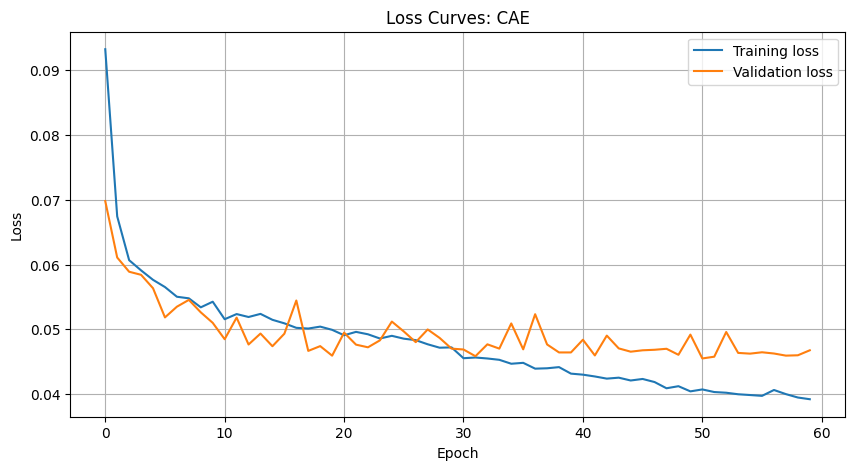

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

train_losses = []
valid_losses = []

batch_size = 50
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = TensorDataset(X_valid_tensor, Y_valid_tensor)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)

cae = ConvAutoencoder().to(device)
criterion = nn.L1Loss()

def train_CAE():
  lr = 0.001
  optimizer = optim.Adam(cae.parameters(), lr, weight_decay=1e-5)
  scheduler = optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.75)
  epochs = 60

  for epoch in range(epochs):
    cae.train()
    train_loss = 0.0
    valid_loss = 0.0
    for data, target in train_loader:
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = cae(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)
    scheduler.step()

    cae.eval()
    with torch.no_grad():
       for data, target in valid_loader:
          data, target = data.to(device), target.to(device)
          output = cae(data)
          loss = criterion(output, target)
          valid_loss += loss.item() * data.size(0)

    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f"epoch: {epoch}, train loss: {loss}, valid loss: {valid_loss}")

train_CAE()
plot_loss_curves(train_losses, valid_losses, "CAE")

In [ ]:
from google.colab import files
import torch

torch.save(cae.state_dict(), "cae_state_colourizer.pth")
files.download("cae_state_colourizer.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model Testing

In [ ]:
import torch

cae = ConvAutoencoder()
cae.load_state_dict(torch.load("cae_state_colourizer.pth"))


<All keys matched successfully>

black and white


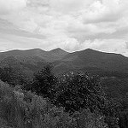

colour image


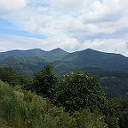

prediction


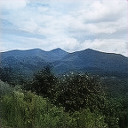

In [ ]:
cae = cae.to("cpu")
pred = predict_and_display_image(cae, 50)

black and white


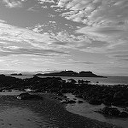

colour image


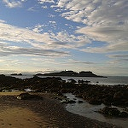

prediction


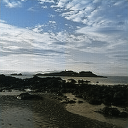

In [ ]:
cae = cae.to("cpu")
pred = predict_and_display_image(cae, 150)

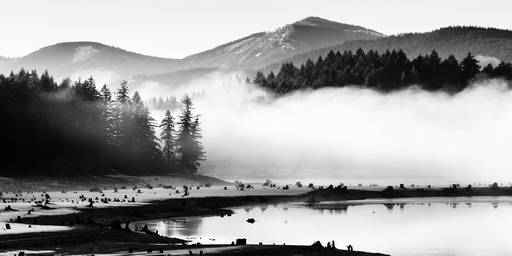

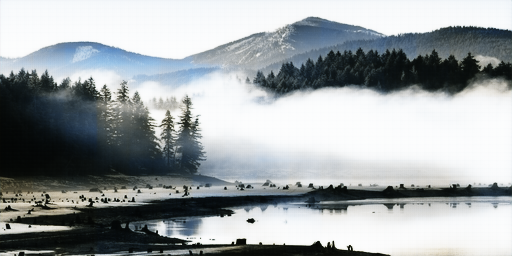

In [ ]:
res = pred_image(cae, "test_image.jpg")

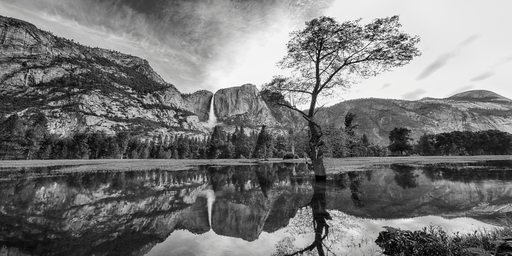

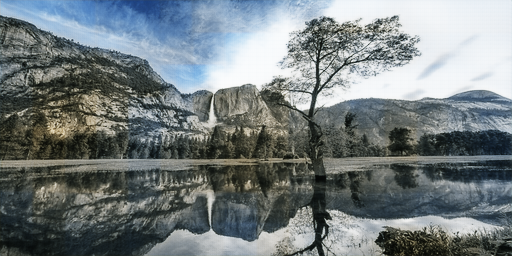

In [ ]:
res = pred_image(cae, "test_image_2.jpg")

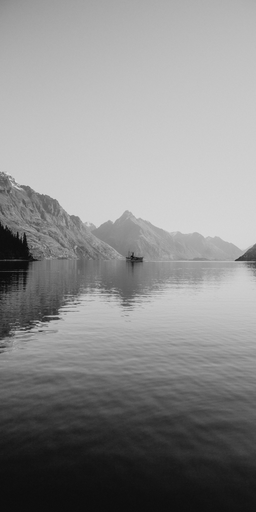

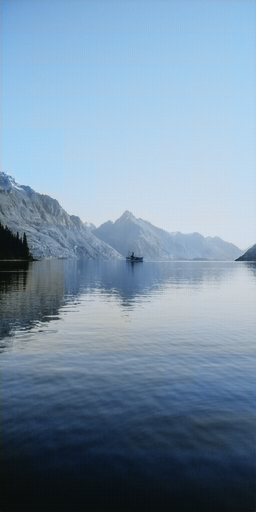

In [ ]:
res = pred_image(cae, "test_image_3.jpg")

### Model Deployment

In [ ]:
import modelbit as mb